In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from nerfstudio.pipelines.base_pipeline import VanillaPipelineConfig
from nerfstudio.utils.eval_utils import eval_setup
from pathlib import Path
config = Path("outputs/garfield_plushie/dig/2024-02-27_144117/config.yml")
_,pipeline,_,_ = eval_setup(config)
dino_loader = pipeline.datamanager.dino_dataloader


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/justin/miniconda3/envs/garfield/lib/python3.10/site-packages/cudf/utils/_numba.py:17: UserWarning: CUDA Toolkit is newer than CUDA driver. Numba features will not work in this configuration. 
  warnings.warn(


[15:00:20] Auto image downscale factor of 2                                                 ]8;id=842055;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=329490;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\

/home/justin/nerfstudio/nerfstudio/cameras/camera_utils.py:460: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:63.)
  v = torch.cross(a, b)


           Caching / undistorting train images                                            ]8;id=323521;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=833374;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py#182\182]8;;\

Output()

[15:00:21] Caching / undistorting eval images                                             ]8;id=602940;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=661387;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py#195\195]8;;\

Output()

Using cache found in /home/justin/.cache/torch/hub/facebookresearch_dino_main


Dino data shape torch.Size([356, 56, 100, 64])


Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/garfield_plushie/dig/2024-02-27_144117/nerfstudio_models/step-000008000.ckpt

10.75


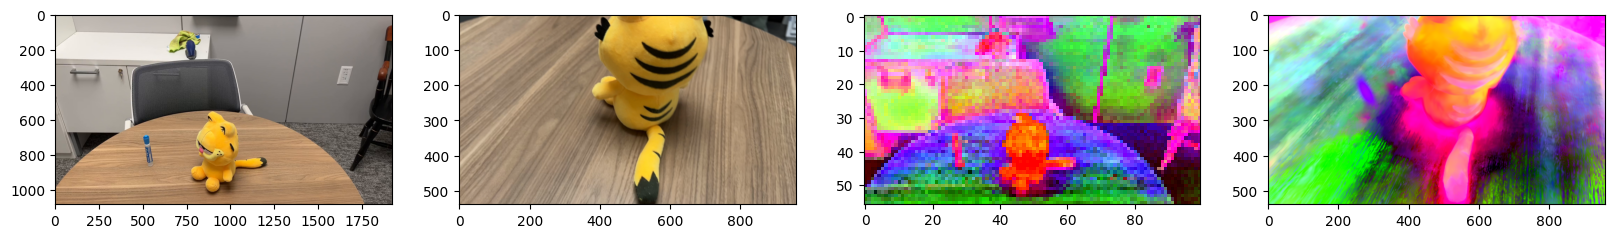

In [72]:
from PIL import Image
from torchvision.transforms import ToTensor
import moviepy.editor as mpy
# image_path = Path("/home/justin/nerfstudio/data/garfield_plushie/images/frame_00100.png")
video_path = Path("/home/justin/Downloads/garfield_move.mp4")
clip = mpy.VideoFileClip(str(video_path))
#print length of video in seconds
print(clip.duration)
clip.save_frame("frame.png", t=7.0)
image_path = Path("frame.png")


# image_path = Path("/home/justin/nerfstudio/data/colorful_mugs_colmap/images/frame_00010.jpg")
# image_path = Path("/home/justin/nerfstudio/data/louvre_statue/images/frame_00020.png")
pil_image = ToTensor()(Image.open(image_path))
img_pca_feats = dino_loader.get_pca_feats(pil_image.unsqueeze(0)).cuda().squeeze()
cam,data = pipeline.datamanager.next_train(0)
outputs = pipeline.model.get_outputs_for_camera(cam)
which_to_rgb_pca = torch.cat([outputs['dino'].view(-1,img_pca_feats.shape[-1]),img_pca_feats.view(-1,img_pca_feats.shape[-1])],dim=0)
_,_,rgb_pca = torch.pca_lowrank(which_to_rgb_pca.view(-1,which_to_rgb_pca.shape[-1]), q=3, niter=20)
from nerfstudio.utils.colormaps import apply_pca_colormap
_,axs = plt.subplots(1,4,figsize=(20,10))
axs[0].imshow(pil_image.permute(1,2,0).cpu().numpy())
axs[1].imshow(data["image"].cpu().numpy())
axs[2].imshow(apply_pca_colormap(img_pca_feats,rgb_pca).cpu().numpy())
axs[3].imshow(apply_pca_colormap(outputs["dino"],rgb_pca).cpu().numpy())
plt.show()

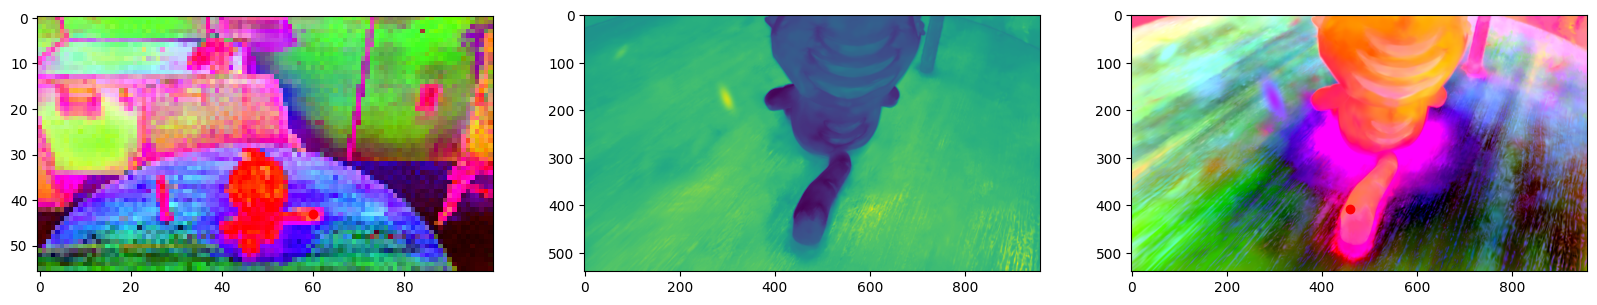

In [70]:
#rite code to choose a pixel coordinate in the img_pca_feats, compare that distance to the outputs['dino'] features, and visualize the feature distance with matplotlib?
# pix_coords = (12,13)#marker
# pix_coords = (30,69)#tail tip
# pix_coords = (40,40)#left leg
# pix_coords = (30,33)#right leg
#above are locations for frame_00055
pix_coords = (43,60)
img_pca_feat = img_pca_feats[pix_coords[0],pix_coords[1],:]
distance_img = (outputs['dino'] - img_pca_feat).pow(2).sum(dim=-1).sqrt()[...,None]

_,axs = plt.subplots(1,3,figsize=(20,10))
#visualize the input click on the original image
axs[0].imshow(apply_pca_colormap(img_pca_feats,rgb_pca).cpu().numpy())
axs[0].scatter(pix_coords[1],pix_coords[0],c="r")
axs[1].imshow(distance_img.squeeze().cpu().numpy())
axs[2].imshow(apply_pca_colormap(outputs["dino"],rgb_pca).cpu().numpy())
#compute the argmin of the distance_img and plot it on the outputs['dino'] image
argmin = torch.argmin(distance_img).cpu().numpy()
argmin_coords = (argmin//distance_img.shape[1],argmin%distance_img.shape[1])
axs[2].scatter(argmin_coords[1],argmin_coords[0],c="r")
plt.show()